In [1]:
### Preamble
# Math and data processing
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.time import Time
from math import sqrt, pi
from scipy.io import readsav
from importlib import reload
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
# Self-defined
import ML_util as util
import plot_util as p_util
import keck_data_compiler as comp
# Data directories
data_dir = "data/"
steve_file = data_dir+"lgs_metadata.fits"
plot_dir = "plots/"
steve_plots = plot_dir+"steve_plots/"
NAN_YEAR = 1858.876712328767

In [33]:
### Read in Steve's data
file = Table.read(steve_file, format='fits')
steve_data = file.to_pandas()
print(steve_data.columns)
steve_data.describe()

Index(['file', 'strehl', 'rms_err', 'fwhm', 'mjd', 'epoch', 'airmass', 'itime',
       'coadds', 'band', 'az', 'dmgain', 'dtgain', 'wsfrrt', 'aolbfwhm',
       'lsamppwr', 'lgrmswf', 'xref', 'yref', 'xstrehl', 'ystrehl', 'MASS',
       'MASS_mjd', 'MASS_delta_t', 'DIMM', 'DIMM_mjd', 'DIMM_delta_t',
       'MASSPRO_half', 'MASSPRO_1', 'MASSPRO_2', 'MASSPRO_4', 'MASSPRO_8',
       'MASSPRO_16', 'MASSPRO', 'MASSPRO_mjd', 'MASSPRO_delta_t',
       'wind_speed[kts]', 'wind_speed', 'wind_direction', 'temperature',
       'relative_humidity', 'pressure[mb]', 'pressure', 'cfht_mjd',
       'cfht_delta_t'],
      dtype='object')


,strehl,rms_err,fwhm,mjd,airmass,itime,coadds,az,dmgain,dtgain,...,MASSPRO_delta_t,wind_speed[kts],wind_speed,wind_direction,temperature,relative_humidity,pressure[mb],pressure,cfht_mjd,cfht_delta_t
count,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,...,3281.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.00000,5949.000000,5949.000000,5949.000000,5949.000000
mean,0.281083,383.117079,67.839193,56117.752875,1.583200,2.805354,10.339385,177.907009,0.297084,0.104504,...,-0.225573,11.676542,6.006932,-221.363591,2.357018,23.33720,618.047067,0.618047,56117.748694,0.004181
std,0.100528,51.807862,19.021460,1305.547327,0.094087,0.344479,5.939079,15.797041,0.078659,0.089278,...,0.480427,8.482568,4.363810,1830.418981,1.988321,18.10659,2.042654,0.002043,1305.544130,0.066346
min,-1.000000,-1.000000,-1.000000,53212.346420,1.515730,0.181000,3.000000,138.497840,0.200000,0.010000,...,-1.781127,0.000000,0.000000,-10000.000000,-3.290000,2.00000,611.900000,0.611900,53212.347222,-0.001988
25%,0.233000,350.100000,58.330000,55036.327970,1.524350,2.800000,10.000000,165.695560,0.250000,0.050000,...,-0.006460,5.220000,2.685400,65.000000,1.040000,10.00000,616.700000,0.616700,55036.329167,-0.000220
50%,0.292000,374.700000,63.630000,56132.355430,1.551410,2.800000,10.000000,179.373300,0.250000,0.075000,...,-0.000206,11.000000,5.658889,94.000000,2.450000,16.00000,618.300000,0.618300,56132.355556,0.000007
75%,0.342000,407.600000,72.150000,57243.317310,1.605690,2.800000,10.000000,191.085560,0.350000,0.100000,...,0.000267,16.520000,8.498622,137.000000,3.730000,34.00000,619.600000,0.619600,57243.317361,0.000226
max,0.615000,722.900000,442.630000,57991.296820,2.268440,8.000000,120.000000,204.037230,0.600000,0.500000,...,0.102330,36.520000,18.787511,355.000000,6.880000,80.00000,622.400000,0.622400,57991.296528,1.204238


In [34]:
### Uncomment if you want to reload the metadata file
#comp.update()

In [2]:
### Read in my own data
#reload(util)
my_data = pd.read_csv(data_dir+"keck_metadata.dat")
my_data = util.clean(my_data)
my_data.columns = [x.lower() for x in my_data.columns]
# Add decimal year
year = Time(my_data.mjd, format='mjd').decimalyear
my_data['dec_year'] = year
my_data.columns

Index(['file', 'strehl', 'rms_err', 'fwhm', 'mjd', 'epoch', 'airmass', 'itime',
       'coadds', 'fwiname', 'az', 'dmgain', 'dtgain', 'xref', 'yref',
       'xstrehl', 'ystrehl', 'wsfrrt', 'aolbfwhm', 'lsamppwr', 'lgrmswf',
       'aoaoamed', 'tubetemp', 'mass_mjd', 'dimm_mjd', 'masspro_mjd',
       'cfht_mjd', 'mass', 'dimm', 'masspro_half', 'masspro_1', 'masspro_2',
       'masspro_4', 'masspro_8', 'masspro_16', 'masspro', 'wind_speed',
       'wind_direction', 'temperature', 'relative_humidity', 'pressure',
       'dec_year'],
      dtype='object')

In [3]:
data = my_data
count=0
for i,col in enumerate(data.columns):
    if col=='file' or col=='epoch' or col=='band' or col=='fwiname':
        continue
    nans = np.isnan(data[col]).sum()
    print(f"col {col} has {nans} nans", end="\t\t")
    if count%3==0:
        print()
    count+=1

col strehl has 0 nans		
col rms_err has 0 nans		col fwhm has 0 nans		col mjd has 0 nans		
col airmass has 0 nans		col itime has 0 nans		col coadds has 0 nans		
col az has 0 nans		col dmgain has 0 nans		col dtgain has 0 nans		
col xref has 0 nans		col yref has 0 nans		col xstrehl has 0 nans		
col ystrehl has 0 nans		col wsfrrt has 0 nans		col aolbfwhm has 564 nans		
col lsamppwr has 0 nans		col lgrmswf has 0 nans		col aoaoamed has 0 nans		
col tubetemp has 0 nans		col mass_mjd has 2650 nans		col dimm_mjd has 1831 nans		
col masspro_mjd has 2650 nans		col cfht_mjd has 0 nans		col mass has 2650 nans		
col dimm has 1831 nans		col masspro_half has 2650 nans		col masspro_1 has 2650 nans		
col masspro_2 has 2650 nans		col masspro_4 has 2650 nans		col masspro_8 has 2650 nans		
col masspro_16 has 2650 nans		col masspro has 2650 nans		col wind_speed has 0 nans		
col wind_direction has 0 nans		col temperature has 0 nans		col relative_humidity has 0 nans		
col pressure has 0 nans		col dec_year has

In [6]:
data=steve_data
count=0
for i,col in enumerate(data.columns):
    if col=='file' or col=='epoch' or col=='band' or col=='fwiname':
        continue
    nans = np.isnan(data[col]).sum()
    print(f"col {col} has {nans} nans", end="\t\t")
    if count%3==0:
        print()
    count+=1

col strehl has 0 nans		
col rms_err has 0 nans		col fwhm has 0 nans		col mjd has 0 nans		
col airmass has 0 nans		col itime has 0 nans		col coadds has 0 nans		
col az has 0 nans		col dmgain has 0 nans		col dtgain has 0 nans		
col wsfrrt has 0 nans		col aolbfwhm has 574 nans		col lsamppwr has 10 nans		
col lgrmswf has 10 nans		col xref has 0 nans		col yref has 0 nans		
col xstrehl has 0 nans		col ystrehl has 0 nans		col MASS has 2668 nans		
col MASS_mjd has 2668 nans		col MASS_delta_t has 2668 nans		col DIMM has 2668 nans		
col DIMM_mjd has 2668 nans		col DIMM_delta_t has 2668 nans		col MASSPRO_half has 2703 nans		
col MASSPRO_1 has 2703 nans		col MASSPRO_2 has 2705 nans		col MASSPRO_4 has 2705 nans		
col MASSPRO_8 has 2700 nans		col MASSPRO_16 has 2698 nans		col MASSPRO has 2697 nans		
col MASSPRO_mjd has 2668 nans		col MASSPRO_delta_t has 2668 nans		col wind_speed[kts] has 0 nans		
col wind_speed has 0 nans		col wind_direction has 0 nans		col temperature has 0 nans		
col relative_humi

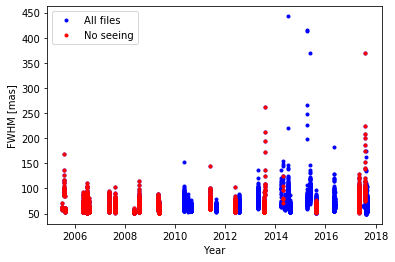

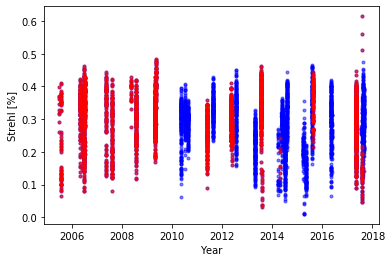

In [41]:
### Methods section figure: Data Sets
### Which NIRC2 observations have weather, seeing, and telemetry data

# Find NaN values
no_seeing = my_data[np.isnan(my_data.mass_mjd)]

# Find decimal year
all_dates = Time(my_data.mjd, format='mjd').decimalyear
no_seeing_dates = Time(no_seeing.mjd, format='mjd').decimalyear

plt.plot(all_dates, my_data.fwhm, 'b.', label="All files")

plt.plot(no_seeing_dates, no_seeing.fwhm, 'r.', label="No seeing")
plt.legend()

plt.xlabel("Year")
plt.ylabel("FWHM [mas]")
plt.savefig(plot_dir+"FWHM_data.png", bbox_inches='tight')
plt.show()

plt.plot(all_dates, my_data.strehl, 'b.', alpha=0.5)
plt.plot(no_seeing_dates, no_seeing.strehl, 'r.', alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Strehl [%]")
plt.savefig(plot_dir+"strehl_data.png", bbox_inches='tight')
plt.show()

In [22]:
np.isnan(my_data.mass_mjd[10])

True

### Methods: Weather Analysis

In [45]:
### Read in my data
#reload(util)
data = pd.read_csv(data_dir+"keck_metadata.dat")
data = util.clean(data)
data.columns = [x.lower() for x in data.columns]
data['dec_year'] = Time(data.mjd, format='mjd').decimalyear
data.columns

Index(['file', 'strehl', 'rms_err', 'fwhm', 'mjd', 'epoch', 'airmass', 'itime',
       'coadds', 'fwiname', 'az', 'dmgain', 'dtgain', 'xref', 'yref',
       'xstrehl', 'ystrehl', 'wsfrrt', 'aolbfwhm', 'lsamppwr', 'lgrmswf',
       'aoaoamed', 'tubetemp', 'mass_mjd', 'dimm_mjd', 'masspro_mjd',
       'cfht_mjd', 'mass', 'dimm', 'masspro_half', 'masspro_1', 'masspro_2',
       'masspro_4', 'masspro_8', 'masspro_16', 'masspro', 'wind_speed',
       'wind_direction', 'temperature', 'relative_humidity', 'pressure',
       'dec_year'],
      dtype='object')

In [49]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

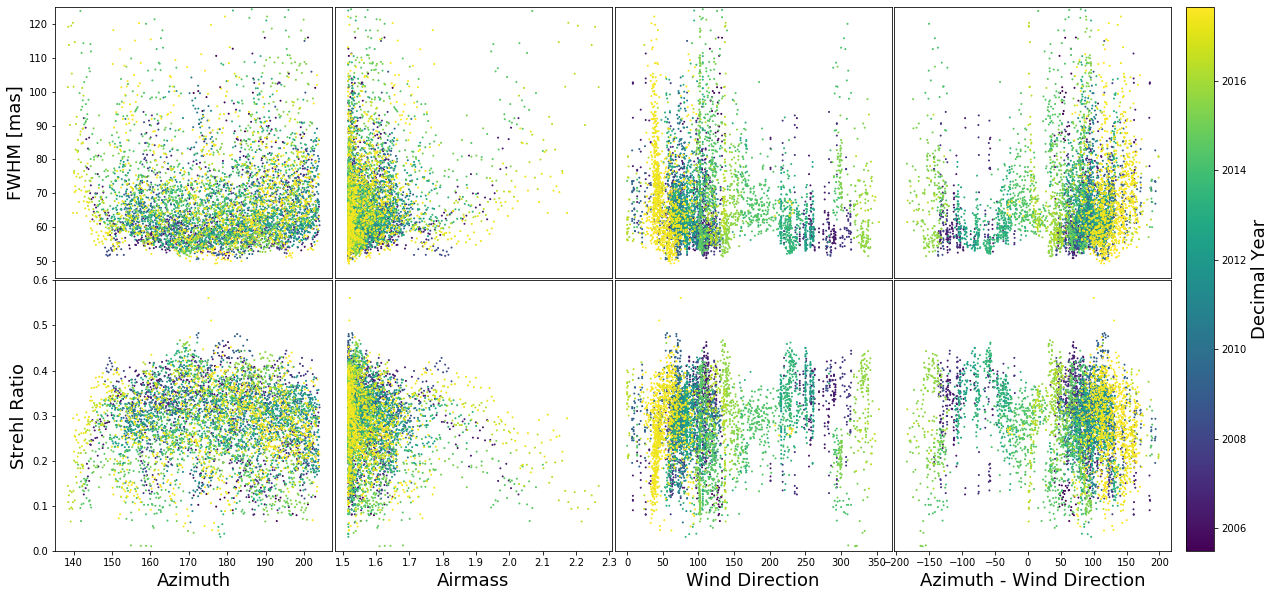

In [55]:
### First data-on-data plot:
### Azimuth, Airmass, Wind Direction, Azimuth - Wind Direction vs. image quality
settings = p_util.default_settings.copy()
settings['label'].update({'az-wdir':'Azimuth - Wind Direction'})
data['az-wdir'] = data['az']-data['wind_direction']
x_vars = ['az', 'airmass', 'wind_direction', 'az-wdir']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, settings=settings, save=False)

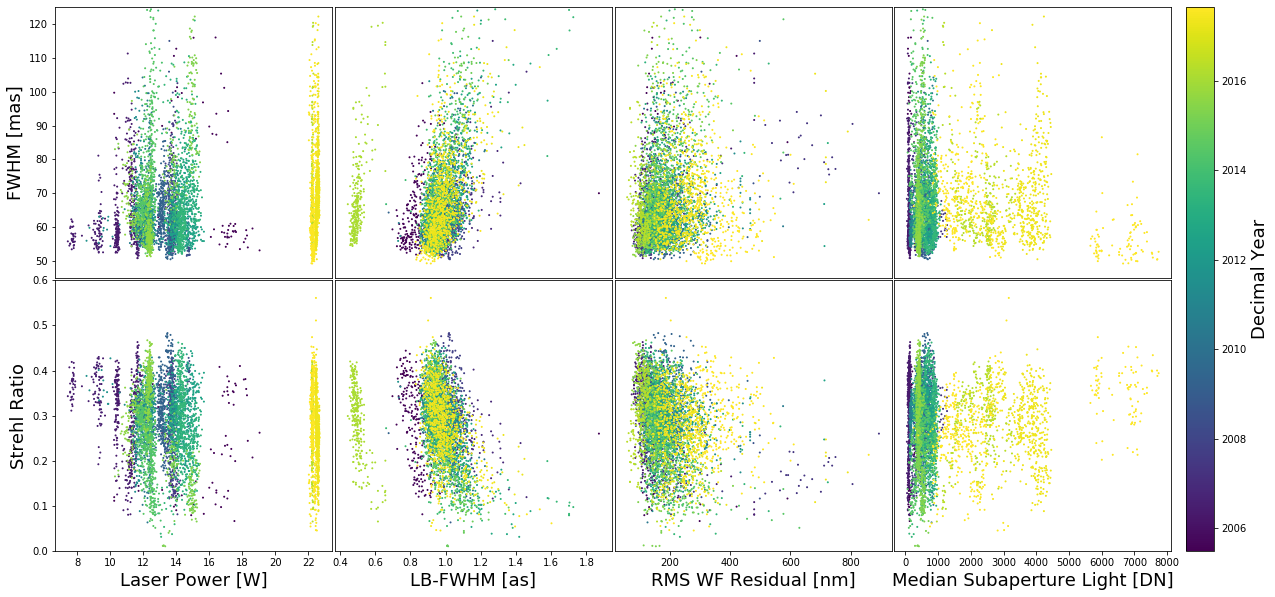

In [56]:
### Second data-on-data plot:
### AOAOMED, LSAMPPWR, AOLBFWHM, LGRMSWF vs. strehl and fwhm
x_vars = ['lsamppwr', 'aolbfwhm', 'lgrmswf', 'aoaoamed']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, save=False)

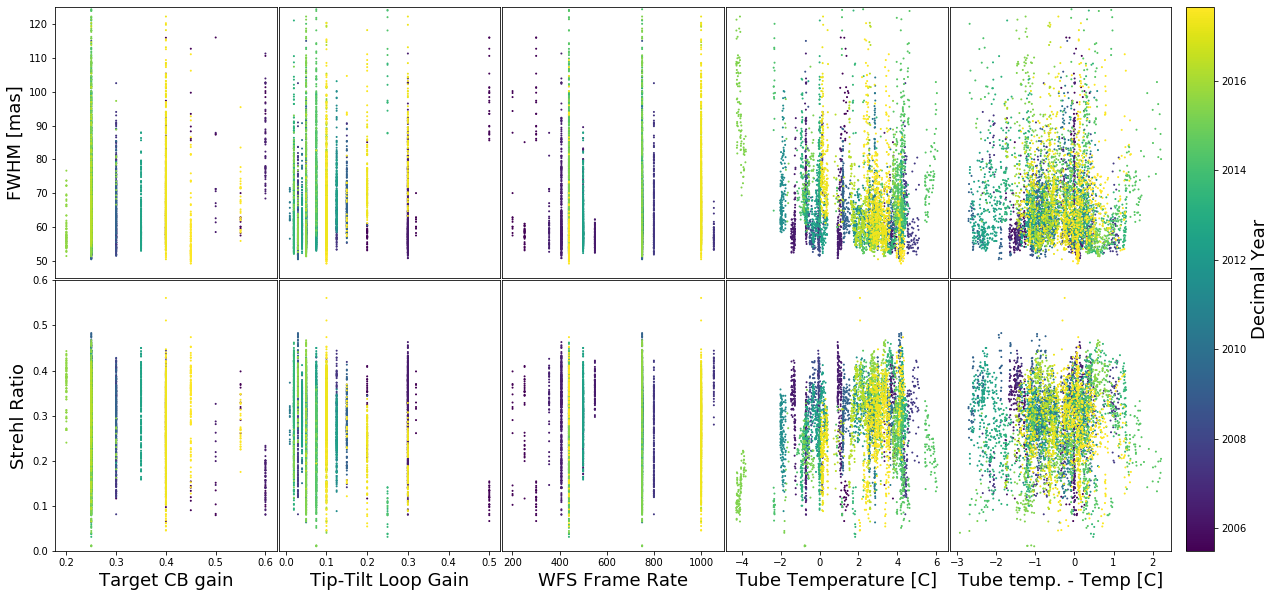

In [57]:
### Third data-on-data plot:
### Should be tubetemp, dmgain, dtgain, and wsfrrt, but tubetemp is missing
settings = p_util.default_settings.copy()
settings['label'].update({'ttemp-temp':'Tube temp. - Temp [C]'})
data['ttemp-temp'] = data['tubetemp']-data['temperature']

x_vars = ['dmgain', 'dtgain', 'wsfrrt', 'tubetemp', 'ttemp-temp']
y_vars = ['fwhm', 'strehl']

p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, settings=settings, save=False)

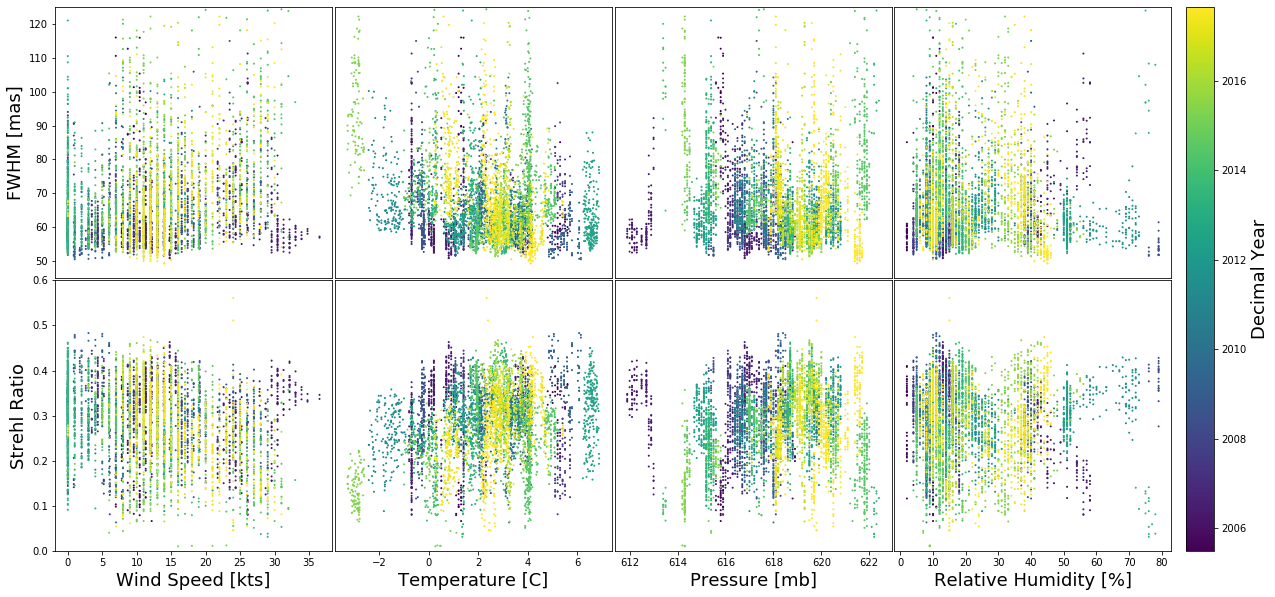

In [58]:
### Fourth data-on-data plot
### No variables missing
x_vars = ['wind_speed', 'temperature', 'pressure', 'relative_humidity']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', fontsize=18, save=False)

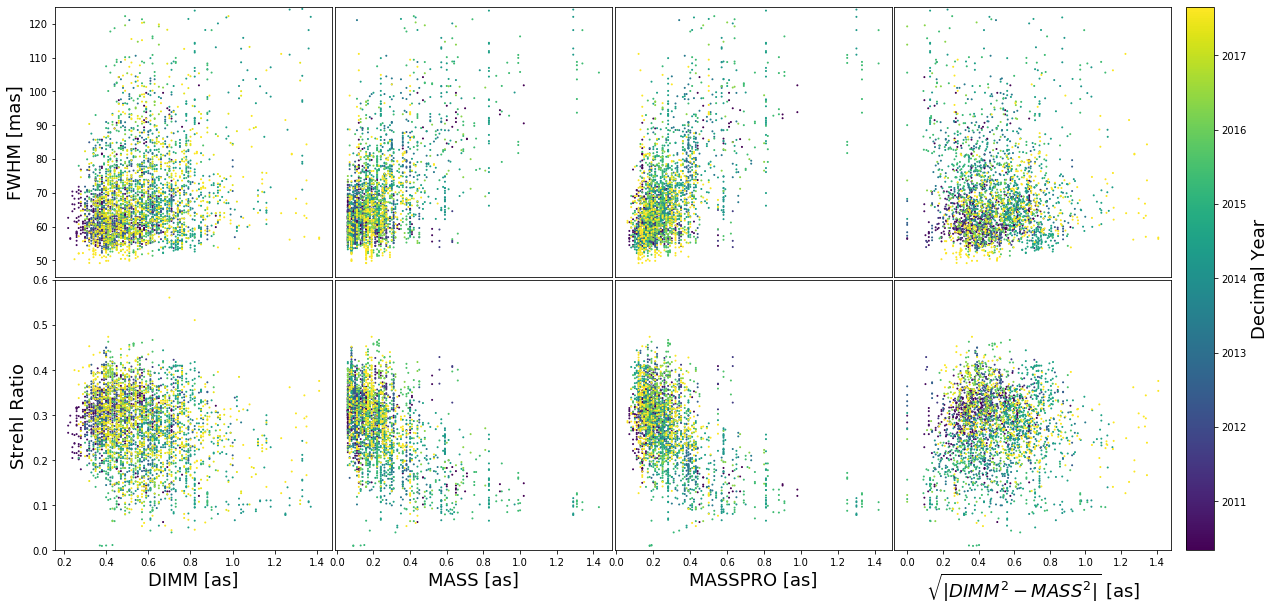

In [59]:
settings = p_util.default_settings.copy()
settings['label'].update({'sqrt-d2-m2':'$\sqrt{|DIMM^2-MASS^2|}$ [as]'})
data['sqrt-d2-m2'] = np.sqrt(np.abs(data.dimm**2 - data.mass**2))
x_vars = ['dimm', 'mass', 'masspro', 'sqrt-d2-m2']
y_vars = ['fwhm', 'strehl']

p_util.plot_vars(data, x_vars, y_vars, c_var='dec_year', settings=settings, fontsize=18, save=False)

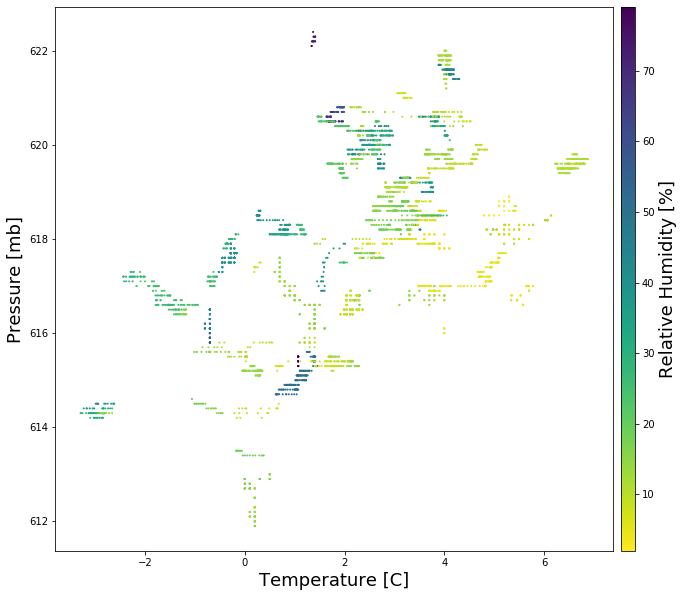

In [60]:
x_vars = ['temperature']
y_vars = ['pressure']
p_util.plot_vars(data, x_vars, y_vars, c_var='relative_humidity', fontsize=18, figsize=(10, 10), cmap='viridis_r')

### Methods: Telemetry Analysis

In [2]:
# Telemetry data
ao_root = 'ao_telemetry/'

In [23]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

In [4]:
# Read in test file
testfile1 = "/g/lu/data/keck_telemetry/20170718/sdata901/nirc15/2017jul18/n0098_LGS_trs.sav"
testfile2 = "/g/lu/data/keck_telemetry/20150402/sdata903/nirc9/2015apr02_B/n0001_fullNGS_trs.sav"
# data = readsav(testfile1)
# Test access to data
# data.a.offsetcentroid[0].shape

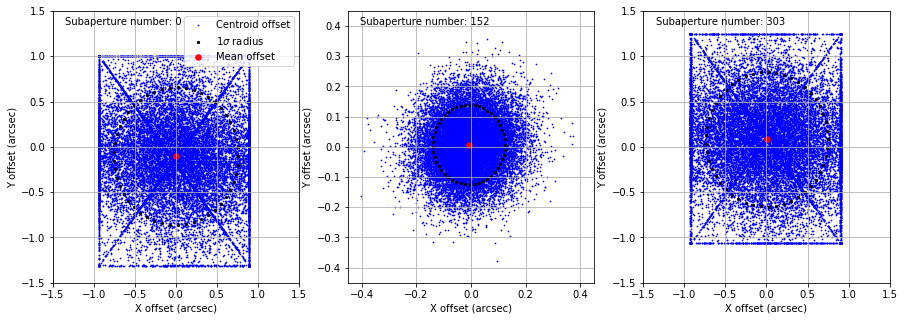

In [5]:
# Test plot function 
p_util.plot_lenslets(testfile1, [0, 152, 303], shape=(1,3), xlim={152:(-.45,.45)})

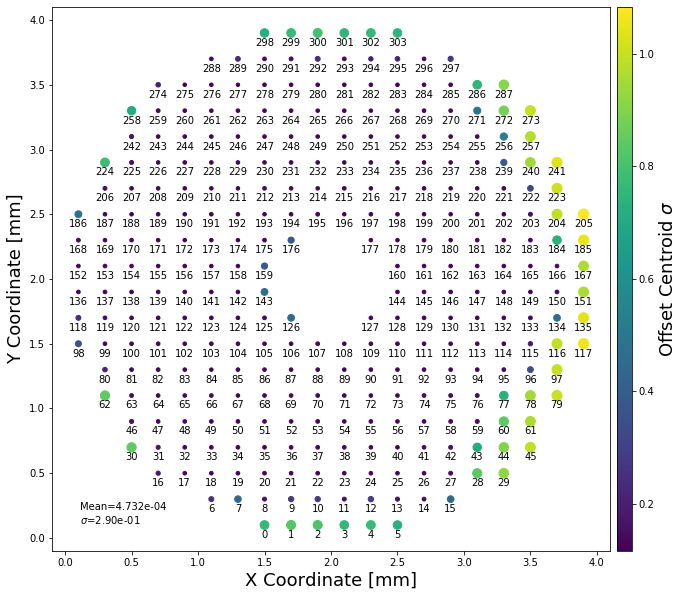

In [24]:
p_util.plot_array(testfile1, save=True)

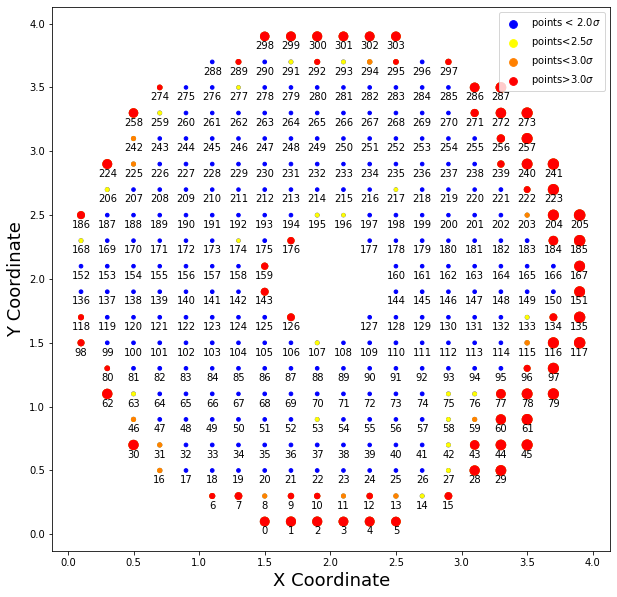

In [8]:
p_util.plot_array(testfile1, sig_clip=[2.0, 2.5, 3.0])

##### Sigma clipping

In [44]:
test = np.array([[1, 1, 1], [1, 2, 1], [1, 1, 7]])
q = sigma_clip(test)
a = q.filled(0)
a[:, 0:2] = (1, 2)
a

array([[1, 2, 1],
       [1, 2, 1],
       [1, 2, 0]])

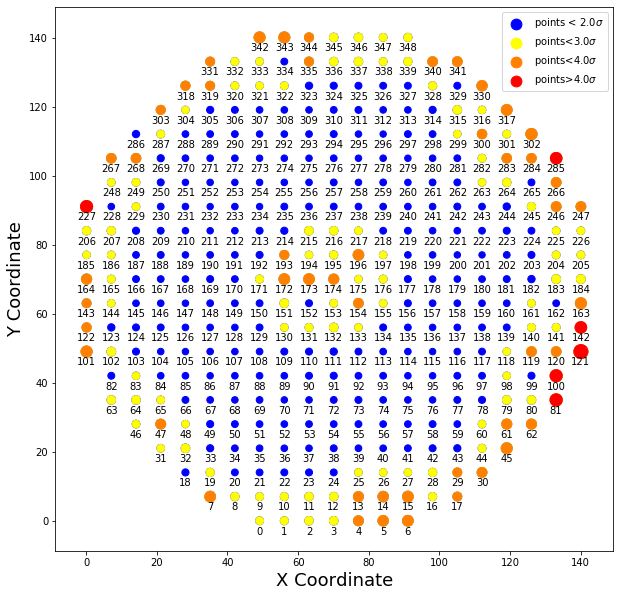

In [8]:
p_util.plot_array(testfile2, data_type='residual wavefront', sig_clip=[2.0, 3.0, 4.0], map_file='ao_telemetry/act.txt',
                  size=200, spacing=7, save=True, cmap=mpl.cm.jet)

In [85]:
### Calculate standard deviation
x_std = np.std(data.a.offsetcentroid[0][:, range(0, 608, 2)], axis=0)
y_std = np.std(data.a.offsetcentroid[0][:, range(1, 608, 2)], axis=0)
std_all = np.sqrt(x_std**2 + y_std**2)

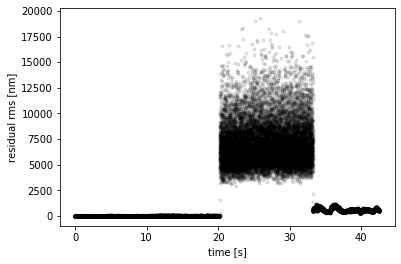

In [12]:
# Different data
testfile3 = "/g/lu/data/keck_telemetry/20170505/sdata904/nirc15/2017may05/n0130_LGS_trs.sav"
data = readsav(testfile3)
res = data.a.residualrms[0][0]
#x = np.linspace(0, len(res)/100, len(res))
x = data.a.timestamp[0]/1e7 # seconds
x -= x[0]
plt.plot(x, res, 'k.', alpha = 0.1, linewidth = 0.5)
plt.xlabel('time [s]')
plt.ylabel('residual rms [nm]')
plt.savefig(p_util.tel_plots+"20170505_high_resid_rms.png")

# Results Section

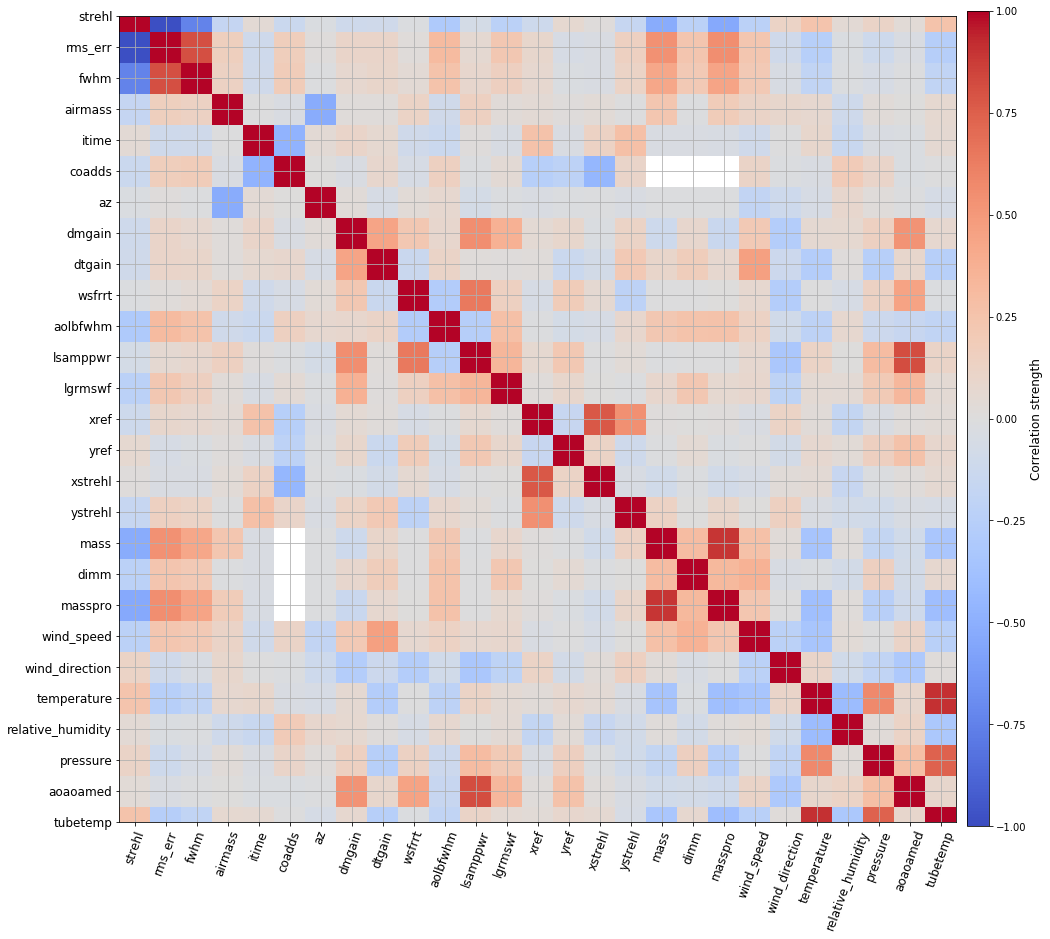

In [8]:
### Plot covariance and correlation plots from Steve's paper
labels = ["strehl", "rms_err", "fwhm", "airmass", "itime", "coadds", "az", "dmgain", "dtgain", "wsfrrt",
          "aolbfwhm", "lsamppwr", "lgrmswf", "xref", "yref", "xstrehl", "ystrehl", "mass", "dimm",
          "masspro", "wind_speed", "wind_direction", "temperature", "relative_humidity", "pressure",
          "aoaoamed", "tubetemp"]
p_util.correlation_matrix(my_data, labels=labels, figsize=(15, 15), save=True)

In [6]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>